In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # Handle class imbalance

import graphviz

In [4]:
path="data/resampled_dataset.csv"

In [5]:
#dataframe csv
df=pd.read_csv(path)
print(df.head())

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0                53         286370                  2                       2   
1                53            741                  2                       2   
2                53          31410                  2                       2   
3             53551           4748                  2                       0   
4               443        5661084                  7                       4   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           80                          266   
1                           54                          178   
2                           60                          174   
3                           12                            0   
4                          635                          168   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                     40                     40            

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746117 entries, 0 to 746116
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             746117 non-null  int64  
 1   Flow Duration                746117 non-null  int64  
 2   Total Fwd Packets            746117 non-null  int64  
 3   Total Backward Packets       746117 non-null  int64  
 4   Total Length of Fwd Packets  746117 non-null  int64  
 5   Total Length of Bwd Packets  746117 non-null  int64  
 6   Fwd Packet Length Max        746117 non-null  int64  
 7   Fwd Packet Length Min        746117 non-null  int64  
 8   Fwd Packet Length Mean       746117 non-null  float64
 9   Fwd Packet Length Std        746117 non-null  float64
 10  Bwd Packet Length Max        746117 non-null  int64  
 11  Bwd Packet Length Min        746117 non-null  int64  
 12  Bwd Packet Length Mean       746117 non-null  float64
 13 

In [7]:
df['Label'].value_counts()

Label
BENIGN                        300000
DoS Hulk                      184858
PortScan                      127144
DDoS                          102422
DoS GoldenEye                   8234
FTP-Patator                     6350
SSH-Patator                     4718
DoS slowloris                   4637
DoS Slowhttptest                4399
Bot                             1573
Web Attack � Brute Force        1205
Web Attack � XSS                 522
Infiltration                      29
Web Attack � Sql Injection        17
Heartbleed                         9
Name: count, dtype: int64

In [8]:
df.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [9]:
df.isnull().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [10]:
#give all columns
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [11]:
df = df.dropna()


In [12]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


In [13]:
X = df.drop(columns=['Label'])  # Feature columns
y = df['Label']  # Target variable


In [14]:
# Check for infinite values
print("Contains infinite values:", np.isinf(X).sum())

# Check for very large values
print("Max value in dataset:", np.max(X))
print("Min value in dataset:", np.min(X))

# Check for NaN values
print("Contains NaN values:", np.isnan(X).sum())


Contains infinite values: Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64
Max value in dataset: inf
Min value in dataset: -6442447920.0
Contains NaN values: Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64


In [15]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
X.fillna(X.max(), inplace=True)  # Replace NaN with max finite value


In [16]:
X.fillna(X.mean(), inplace=True)


In [17]:
X = X.astype(np.float64)


In [18]:
# Feature selection using correlation
corr_matrix = df.corr()
top_features = corr_matrix["Label"].abs().sort_values(ascending=False).head(20).index
df_selected = df[top_features]
df_selected.info("Selected features:")

<class 'pandas.core.frame.DataFrame'>
Index: 745285 entries, 0 to 746116
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Label                    745285 non-null  int64  
 1   PSH Flag Count           745285 non-null  int64  
 2   Min Packet Length        745285 non-null  int64  
 3   Bwd Packet Length Min    745285 non-null  int64  
 4   Init_Win_bytes_forward   745285 non-null  int64  
 5   Bwd Packets/s            745285 non-null  float64
 6   ACK Flag Count           745285 non-null  int64  
 7   URG Flag Count           745285 non-null  int64  
 8   Fwd Packet Length Min    745285 non-null  int64  
 9   Avg Fwd Segment Size     745285 non-null  float64
 10  Fwd Packet Length Mean   745285 non-null  float64
 11  Fwd Packet Length Max    745285 non-null  int64  
 12  Down/Up Ratio            745285 non-null  int64  
 13  Average Packet Size      745285 non-null  float64
 14  Fwd Packe

In [19]:
# Separate features and labels
X = df_selected.drop(columns=['Label'])
y = df_selected['Label']

<Axes: >

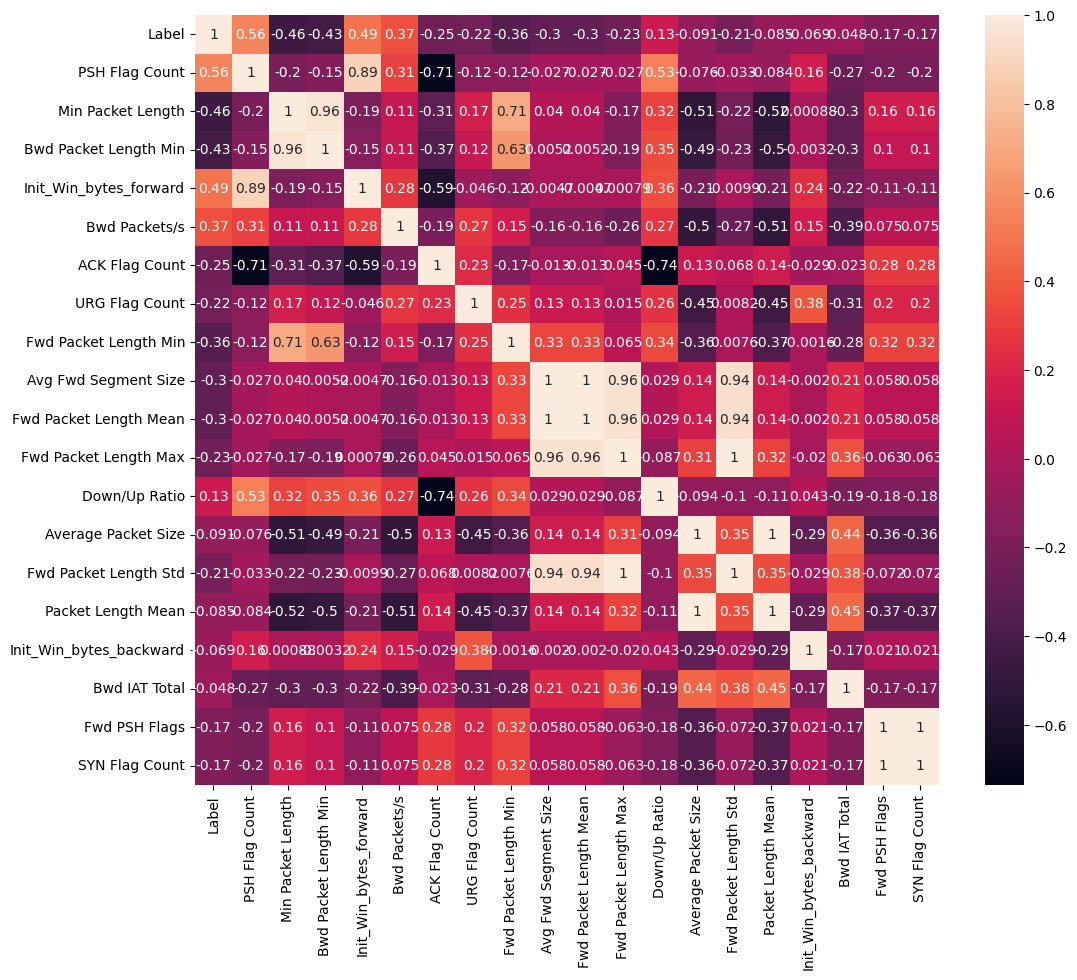

In [20]:
#heatmap for selected features
plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix[top_features].corr(), annot=True)

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [22]:
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  # Reshape for Conv1D


In [23]:
# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [24]:
#find label counts in smote resampled data lists

unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))


{np.int64(0): np.int64(299928),
 np.int64(1): np.int64(299928),
 np.int64(2): np.int64(299928),
 np.int64(3): np.int64(299928),
 np.int64(4): np.int64(299928),
 np.int64(5): np.int64(299928),
 np.int64(6): np.int64(299928),
 np.int64(7): np.int64(299928),
 np.int64(8): np.int64(299928),
 np.int64(9): np.int64(299928),
 np.int64(10): np.int64(299928),
 np.int64(11): np.int64(299928),
 np.int64(12): np.int64(299928),
 np.int64(13): np.int64(299928),
 np.int64(14): np.int64(299928)}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
])
model.summary() 

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 17, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,471 (326.06 KB)

 Trainable params: 83,471 (326.06 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [28]:
with tf.device('/GPU:1'):
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9152 - loss: 0.2779 - val_accuracy: 0.9523 - val_loss: 0.1448
Epoch 2/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - accuracy: 0.9525 - loss: 0.1480 - val_accuracy: 0.9552 - val_loss: 0.1355
Epoch 3/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9543 - loss: 0.1399 - val_accuracy: 0.9558 - val_loss: 0.1297
Epoch 4/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9548 - loss: 0.1373 - val_accuracy: 0.9558 - val_loss: 0.1338
Epoch 5/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9564 - loss: 0.1338 - val_accuracy: 0.9575 - val_loss: 0.1260
Epoch 6/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9565 - loss: 0.1319 - val_accuracy: 0.9572 - val_loss: 0.1266
Epoch 7/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9569 - loss: 0.1302 - val_accuracy: 0.9578 - val_loss: 0.1272
Epoch 8/10
18633/18633 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 

4659/4659 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9585 - loss: 0.1221
Test Accuracy: 95.94%
4659/4659 ━━━━━━━━━━━━━━━━━━━━ 4s 884us/step


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     59893
           1       0.94      0.36      0.52       329
           2       0.93      1.00      0.97     20464
           3       0.96      0.74      0.84      1693
           4       0.96      1.00      0.98     36899
           5       0.72      0.92      0.81       905
           6       0.93      0.67      0.78       911
           7       0.97      0.99      0.98      1323
           9       0.00      0.00      0.00         5
          10       0.96      1.00      0.98     25349
          11       1.00      0.49      0.66       920
          12       0.42      0.85      0.56       267
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00        96

    accuracy                           0.96    149057
   macro avg       0.70      0.64      0.65    149057
weighted avg       0.96      0.96      0.96    149057



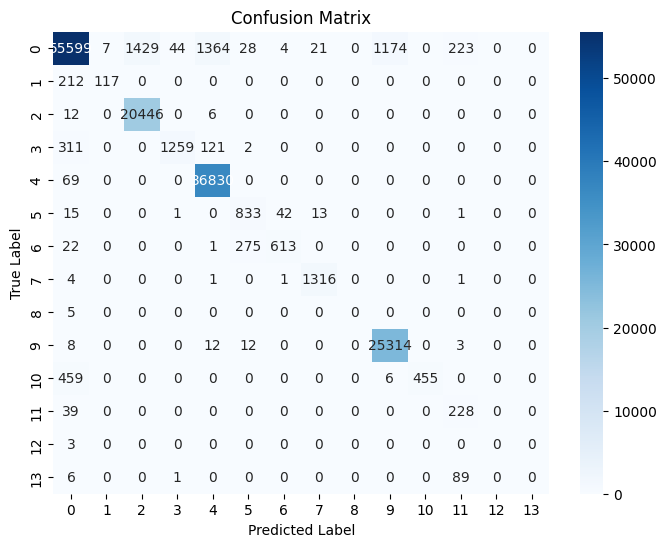

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()





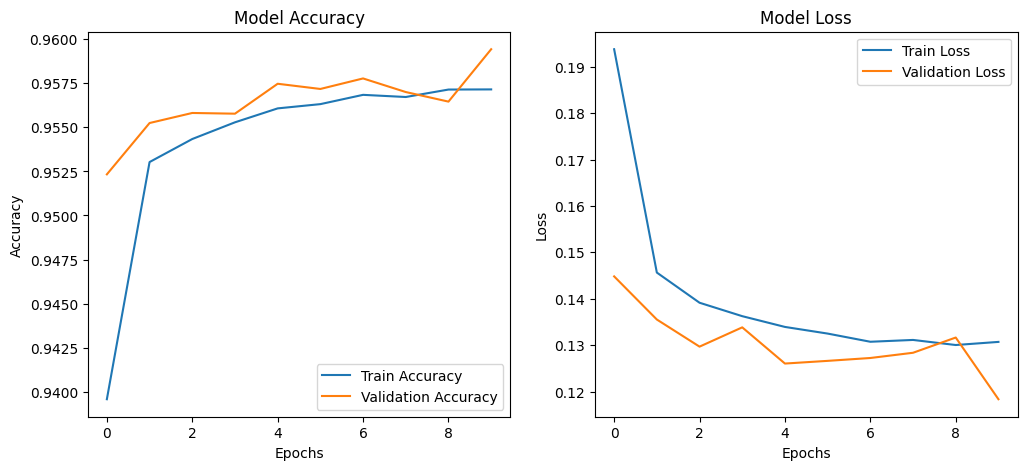

In [30]:
# Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

